## Experiments: Scalability Series Length RSAST

In [19]:
import sys 
import os 
#add sast library path
file_path = os.path.dirname(os.getcwd())+"/sast"

#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.path.dirname(os.getcwd())+"\sast"


#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.getcwd()+"/sast"


#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.getcwd()+"\sast"


#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

#add cd_diagram library path
file_path = os.path.dirname(os.getcwd())+"\cd_diagram"

#file_path = r"C:\Users\Public\random_sast\cd_diagram"
sys.path.append(file_path)


file_path = os.path.dirname(os.getcwd())+"/cd_diagram"
#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.getcwd()+"\cd_diagram"
#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

file_path = os.getcwd()+"/cd_diagram"
#file_path = r"C:\Users\Public\random_sast\sast"
sys.path.append(file_path)

sys.path


['/home/nirojasvar/random_sast/ExperimentationRSAST',
 '/home/nirojasvar/anaconda3/envs/rsast_env/lib/python310.zip',
 '/home/nirojasvar/anaconda3/envs/rsast_env/lib/python3.10',
 '/home/nirojasvar/anaconda3/envs/rsast_env/lib/python3.10/lib-dynload',
 '',
 '/home/nirojasvar/anaconda3/envs/rsast_env/lib/python3.10/site-packages',
 '/home/nirojasvar/random_sast/sast',
 '/home/nirojasvar/random_sast\\sast',
 '/home/nirojasvar/random_sast/ExperimentationRSAST/sast',
 '/home/nirojasvar/random_sast/ExperimentationRSAST\\sast',
 '/home/nirojasvar/random_sast\\cd_diagram',
 '/home/nirojasvar/random_sast/cd_diagram',
 '/home/nirojasvar/random_sast/ExperimentationRSAST\\cd_diagram',
 '/home/nirojasvar/random_sast/ExperimentationRSAST/cd_diagram',
 '/home/nirojasvar/random_sast/ExperimentationRSAST',
 '/home/nirojasvar/random_sast/sast',
 '/home/nirojasvar/random_sast\\sast',
 '/home/nirojasvar/random_sast/ExperimentationRSAST/sast',
 '/home/nirojasvar/random_sast/ExperimentationRSAST\\sast',
 '

### Overall analysis

In [20]:
import time 
import os 
import gc
import numpy as np

import sys
sys.path.append(os.path.abspath("."))

from utils_sast import *
from sast import *

from sklearn.linear_model import RidgeClassifierCV

from sast import from_2d_array_to_nested
from sktime.classification.kernel_based import RocketClassifier
#from sktime.transformations.panel.shapelets import *

from sktime.datasets import load_UCR_UEA_dataset
from matplotlib.ticker import FuncFormatter
from convst.classifiers import R_DST_Ridge


In [21]:


dataset_folder = '/home/local.isima.fr/mimbouop/Univariate_arff' # the folder containing the datasets
ds = 'HouseTwenty' # the dataset to use



#max_exponent = 10 # go up to series of length 2^max_exponent
max_exponent = 10 # go up to series of length 2^max_exponent


X_train_all, y_train = load_UCR_UEA_dataset(name=ds, extract_path='data', split="train", return_type="numpy2d")
X_test_all, y_test_all = load_UCR_UEA_dataset(name=ds, extract_path='data', split="test", return_type="numpy2d")
    
# fill na
#train_ds.fillna(0, axis=1, inplace=True)
#test_ds.fillna(0, axis=1, inplace=True)

#X_train_all, y_train = format_dataset(train_ds, shuffle=True)
#X_test_all, y_test_all = format_dataset(test_ds)

df_result = {}
list_score = []
list_time_fit = []
list_time_test = []
list_dataset = []
list_hyperparameter = []
list_method = []
list_rpoint = []
list_nb_per_class = []
list_series_length = []
list_exp_length = []

for i in range(4, max_exponent+1):

    series_length = 2**i

    X_train = X_train_all[:,:series_length]
    X_test = X_test_all[:X_train.shape[0], :series_length]
    y_test = y_test_all[:X_train.shape[0]]

    max_shp_length = X_train.shape[1]

    

    print("--series_length: 2^"+str(i))
    
    p=30
    k=1
    print("RSAST ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    start = time.time()
    random_state = None
    rsast_ridge = RSAST(n_random_points=p,nb_inst_per_class=k, len_method="both", classifier=clf)
    rsast_ridge.fit(X_train, y_train)
    end = time.time()
    time_fit=end-start

    start = time.time()
    score=rsast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)


    list_dataset.append(ds)
    list_hyperparameter.append("ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    list_rpoint.append(str(p))
    list_nb_per_class.append(str(k))
    list_method.append("RSAST ACF&PACF")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))

    p=10
    k=10
    print("RSAST ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    start = time.time()
    random_state = None
    rsast_ridge = RSAST(n_random_points=p,nb_inst_per_class=k, len_method="both", classifier=clf)
    rsast_ridge.fit(X_train, y_train)
    end = time.time()

    time_fit=end-start

    start = time.time()
    score=rsast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    list_rpoint.append(str(p))
    list_nb_per_class.append(str(k))
    list_method.append("RSAST ACF&PACF")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))

    """

    """
    p=10
    k=10
    print("RSAST All: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    start = time.time()
    random_state = None
    rsast_ridge = RSAST(n_random_points=p,nb_inst_per_class=k, len_method="all", classifier=clf)
    rsast_ridge.fit(X_train, y_train)
    end = time.time()
    time_fit=end-start

    start = time.time()
    score=rsast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("All: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    list_rpoint.append(str(p))
    list_nb_per_class.append(str(k))
    list_method.append("RSAST All")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))
    
    p=10
    k=30
    print("RSAST ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    start = time.time()
    
    rsast_ridge = RSAST(n_random_points=p,nb_inst_per_class=k, len_method="both", classifier=clf)
    rsast_ridge.fit(X_train, y_train)
    end = time.time()

    time_fit=end-start

    start = time.time()
    score=rsast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("ACF&PACF: n_random_points="+str(p)+" nb_inst_per_class="+str(k))
    list_rpoint.append(str(p))
    list_nb_per_class.append(str(k))
    list_method.append("RSAST ACF&PACF")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))

    print("ROCKET: kernels=10_000")

    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

    start = time.time()
    rocket= RocketClassifier(num_kernels=10_000)
    rocket.fit(X_train,y_train)

    end = time.time()
    time_fit=end-start

    start = time.time()
    score=rocket.score(X_test,y_test)
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("ROCKET: num_kernels=10_000")
    list_rpoint.append(str(0))
    list_nb_per_class.append(str(0))
    list_method.append("Rocket")
    list_series_length.append(series_length)
    list_exp_length.append(str(i))

    '''
    min_shp_length = 3
    print("STC: min_shapelet_length="+str(min_shp_length)+" max_shapelet_length="+str(np.inf))
    
    max_shp_length = X_train.shape[1]
    start = time.time()
    #Creating a ShapeletTransform and fitting
    st = ShapeletTransform(min_shapelet_length=min_shp_length, max_shapelet_length=np.inf)
    X_train_sktime = from_2d_array_to_nested(pd.DataFrame(X_train))
    X_test_sktime = from_2d_array_to_nested(pd.DataFrame(X_test))
    st.fit(X_train_sktime, y_train)
    #Making the tranformation of time series and training a RandomForestClassifier model
    X_test_transformed = st.transform(X_test_sktime)
    X_train_transformed = st.transform(X_train_sktime)
    clf = RandomForestClassifier()
    clf.fit(X_train_transformed, y_train)
    
    end = time.time()
    list_score.append(clf.score(X_test_transformed, y_test))
    list_time.append(end-start)
    list_dataset.append(ds)
    list_hyperparameter.append("min_shapelet_length="+str(min_shp_length)+" max_shapelet_length="+str(max_shp_length))
    list_rpoint.append(str(0))
    list_nb_per_class.append(str(0))
    list_method.append("STC")  
    
    k=1
    
    #candidate_lengths = np.arange(min_shp_length, max_shp_length+1)
    clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    min_shp_length = 3
    max_shp_length = X_train.shape[1]
    candidate_lengths = np.arange(3, max_shp_length)
    min_shp_length = min(candidate_lengths)
    max_shp_length = max(candidate_lengths)
    print("SAST: min_shapelet_length="+str(min_shp_length)+" max_shapelet_length=m")
    start = time.time()
    

    random_state = None
    

    sast_ridge = SAST(cand_length_list=candidate_lengths,
                            nb_inst_per_class=k, 
                             classifier=clf)

    sast_ridge.fit(X_train, y_train)
    end = time.time()
    time_fit=end-start

    start = time.time()
    score=sast_ridge.score(X_test, y_test) 
    end = time.time()
    time_test=end-start

    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("SAST: min_shapelet_length="+str(min_shp_length)+" max_shapelet_length=m")
    list_rpoint.append(str(0))
    list_nb_per_class.append(str(0))
    list_method.append("SAST")  
    list_series_length.append(series_length)
    list_exp_length.append(str(i))
    '''
    
    print("RDST: n_shapelets=10_000")

    X_train_rdst=X_train[:, np.newaxis, :]
    y_train_rdst=np.asarray([int(x_s) for x_s in y_train])

    X_test_rdst=X_test[:, np.newaxis, :]
    y_test_rdst=np.asarray([int(x_s) for x_s in y_test])

    start = time.time()

    rdst = R_DST_Ridge(n_shapelets=10_000)
    rdst.fit(X_train_rdst, y_train_rdst)
    end = time.time()
    time_fit=end-start
    start = time.time()
    score=rdst.score(X_test_rdst, y_test_rdst)
    end = time.time()
    time_test=end-start
    
    list_score.append(score)
    list_time_fit.append(time_fit)
    list_time_test.append(time_test)

    list_dataset.append(ds)
    list_hyperparameter.append("RDST: n_shapelets=10_000")
    list_rpoint.append(str(0))
    list_nb_per_class.append(str(0))
    list_method.append("RDST")  
    list_series_length.append(series_length)
    list_exp_length.append(str(i))

    
    

df_result['accuracy']=list_score
df_result['time_fit']=list_time_fit
df_result['time_test']=list_time_test
df_result['dataset_name']=list_dataset
df_result['hyperparameter']=list_hyperparameter
df_result['rpoint']=list_rpoint
df_result['nb_per_class']=list_nb_per_class
df_result['classifier_name']=list_method
df_result['series_length']=list_series_length
df_result['exp_length']=list_exp_length

df_result=pd.DataFrame(df_result)
# export a overall dataset with the comparison
df_result.to_csv("results_comparison_accuracy/df_overall_comparison_scalability_series_length.csv")
    #  Write results
    #result = [series_length, sast_time_fit, sast_time_test, sast_fixed_time_fit, sast_fixed_time_test, saste_time_fit, saste_time_test, saste_fixed_time_fit, saste_fixed_time_test, stc_time_fit, stc_time_test]
    #f.write(','.join(np.array(result, dtype=np.str)) + '\n')

print('--All done')


--series_length: 2^4
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:10
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=10
total kernels:321
RSAST All: n_random_points=10 nb_inst_per_class=10
total kernels:1900
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=30
total kernels:690
ROCKET: kernels=10_000
RDST: n_shapelets=10_000
--series_length: 2^5
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:102
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=10
total kernels:694
RSAST All: n_random_points=10 nb_inst_per_class=10
total kernels:5100
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=30
total kernels:1290
ROCKET: kernels=10_000
RDST: n_shapelets=10_000
--series_length: 2^6
RSAST ACF&PACF: n_random_points=30 nb_inst_per_class=1
total kernels:900
RSAST ACF&PACF: n_random_points=10 nb_inst_per_class=10
total kernels:2030
RSAST All: n_random_points=10 nb_inst_per_class=10
total kernels:11500
RSAST ACF&PACF: n_random_points=10 nb_in

In [36]:
df_result=pd.read_csv("results_comparison_accuracy/df_overall_comparison_scalability_series_length.csv")
df_result["hyperparameter"].unique()


array(['ACF&PACF: n_random_points=30 nb_inst_per_class=1',
       'ACF&PACF: n_random_points=10 nb_inst_per_class=10',
       'All: n_random_points=10 nb_inst_per_class=10',
       'ACF&PACF: n_random_points=10 nb_inst_per_class=30',
       'ROCKET: num_kernels=10_000', 'RDST: n_shapelets=10_000'],
      dtype=object)

In [37]:
df_result=df_result[df_result["hyperparameter"].isin(["RDST: n_shapelets=10_000","ACF&PACF: n_random_points=30 nb_inst_per_class=1","ROCKET: num_kernels=10_000"])]
df_result

,Unnamed: 0,accuracy,time_fit,time_test,dataset_name,hyperparameter,rpoint,nb_per_class,classifier_name,series_length,exp_length
0,0,0.575,0.015500,0.001449,HouseTwenty,ACF&PACF: n_random_points=30 nb_inst_per_class=1,30,1,RSAST ACF&PACF,16,4
4,4,0.425,0.303537,0.116329,HouseTwenty,ROCKET: num_kernels=10_000,0,0,Rocket,16,4
5,5,0.675,0.013325,0.008688,HouseTwenty,RDST: n_shapelets=10_000,0,0,RDST,16,4
6,6,0.700,0.027790,0.030389,HouseTwenty,ACF&PACF: n_random_points=30 nb_inst_per_class=1,30,1,RSAST ACF&PACF,32,5
10,10,0.675,0.437859,0.178435,HouseTwenty,ROCKET: num_kernels=10_000,0,0,Rocket,32,5
11,11,0.650,0.030399,0.006395,HouseTwenty,RDST: n_shapelets=10_000,0,0,RDST,32,5
12,12,0.475,0.297652,0.258556,HouseTwenty,ACF&PACF: n_random_points=30 nb_inst_per_class=1,30,1,RSAST ACF&PACF,64,6
16,16,0.625,0.692786,0.310861,HouseTwenty,ROCKET: num_kernels=10_000,0,0,Rocket,64,6
17,17,0.625,0.099351,0.041228,HouseTwenty,RDST: n_shapelets=10_000,0,0,RDST,64,6
18,18,0.475,1.680233,1.566437,HouseTwenty,ACF&PACF: n_random_points=30 nb_inst_per_class=1,30,1,RSAST ACF&PACF,128,7


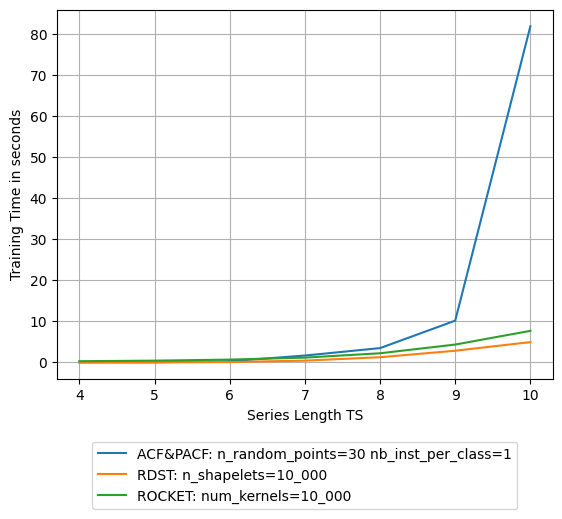

In [38]:

df_result["log_series_length"]=np.log2(df_result["series_length"])
#df_result=df_result[df_result["log_series_length"].isin([5,6,7,8,9,10])]
df_result.pivot_table(values="time_fit", index="log_series_length", columns="hyperparameter").plot.line(grid=True, xlabel="Series Length TS", ylabel="Training Time in seconds")


#place legend in center right of plot
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')

# Define the custom formatter function
def exponent_of_2(x, pos):
    return r'$2^{{{}}}$'.format(int(x))



# Set the x-axis formatter as the custom formatter function
#plt.gca().xaxis.set_major_formatter(FuncFormatter(exponent_of_2))